# Proxy for the Mtm of swaps :

In [2]:
project_path = r'C:\Users\omirinioui\PycharmProjects\Projet Quadrature bayésienne'

In [3]:
lib_path = project_path+'\libraries'
port_path = project_path + '\Data\portfolio'
zc_curve_path = project_path+'\Data\ZC Curve'
diff_path = project_path + '\Data\Diffusion'
MC_path =  project_path +'\Results\Full MC'
img_path = project_path +'\Results\Images'


In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import pandas as pd

import  numpy as np

from time import time
from datetime import timedelta

# importing pacakge 
import sys         
sys.path.append(lib_path)        

from main import *
from FinancialData import *
from Chebychev import *

In [5]:
def GPR_Mtm_ploter(t, diff, irs, ZC, nodes_nbr, diag=False) :
    train_range = (min(diff.X(t)) , max(diff.X(t)) )

    # Pricing to train
    train_points = np.linspace(train_range[0], train_range[1], nodes_nbr)
    mtm_points = irs.Mtm_mono(t,train_points,ZC,diff.get_LGM_params())

    # Train
    gpr_model = GaussianProcessRegressor(kernel = kernel, normalize_y=True)
    gpr_model.fit(train_points.reshape(nodes_nbr,1), mtm_points.reshape(nodes_nbr,1))


    # Mtm Proxy
    Mtm = gpr_predictor(gpr_model, np.sort(diff.X(t)).reshape(diff.nbr_scenarios,1))
    Mtm_true = irs.Mtm_mono(t, np.sort(diff.X(t)),ZC,diff.get_LGM_params())
    
    if diag :
        plt.plot(Mtm_true,  Mtm_true, c = 'red', label = 'true')
        plt.scatter(Mtm_true, Mtm.reshape(diff.nbr_scenarios), label ='GPR')

        plt.xlabel('True Mtm', fontsize = 15)   
        plt.ylabel('GPR', fontsize = 15) 
        plt.legend()
        plt.title(str(nodes_nbr)+' training points', fontdict = {'fontsize':16})
        plt.show()
    else :  
        N = 400
        x_range = np.linspace(train_range[0], train_range[1], N)
        plt.plot(x_range, irs.Mtm_mono(t, x_range,ZC,diff.get_LGM_params()) , label='True')

        plt.scatter(train_points,mtm_points,c='r')

        plt.plot(np.sort(diff.X(t)) , Mtm.reshape(diff.nbr_scenarios) , label='GPR')

        plt.legend()
        plt.xlabel('$X_{t}$')
        plt.ylabel(' Mark-to-Market')
        plt.title(str(nodes_nbr) + ' training points' )
        plt.show()

def Chebyshev_Mtm_ploter(t, diff, irs, ZC, nodes_nbr,diag=False) :
    train_range = (min(diff.X(t)) , max(diff.X(t)) )

    # Pricing to train
    train_points = np.sort(Chebyshev_points(train_range[0], train_range[1], nodes_nbr))
    mtm_points = irs.Mtm_mono(t,train_points,ZC,diff.get_LGM_params())


    # Mtm Proxy
    Mtm = np.array([eval_Barycentric(mtm_points, train_points, x) for x in np.sort(diff.X(t))])
    Mtm_true = irs.Mtm_mono(t, np.sort(diff.X(t)),ZC,diff.get_LGM_params())
    
    if diag :
        plt.plot(Mtm_true,  Mtm_true, c = 'red', label = 'true')
        plt.scatter(Mtm_true, Mtm, label ='Chebyshev')

        plt.xlabel('True Mtm', fontsize = 15)   
        plt.ylabel('Chebyshev', fontsize = 15) 
        plt.legend()
        plt.title(str(nodes_nbr)+' training points', fontdict = {'fontsize':16})
        plt.show()
        
    else :  
        N = 400
        x_range = np.linspace(train_range[0], train_range[1], N)
        plt.plot(x_range, irs.Mtm_mono(t, x_range,ZC,diff.get_LGM_params()) , label='true')

        plt.scatter(train_points,mtm_points,c='r')
        plt.plot(np.sort(diff.X(t)) , Mtm , label='Chebyshev')

        plt.legend()
        plt.xlabel('$X_{t}$')
        plt.ylabel(' Mark-to-Market')
        plt.title(str(nodes_nbr) + ' training points' )
        plt.show()

def Chebyshev_Mtm(t, diff, irs, ZC, nodes_nbr) :
    train_range = (min(diff.X(t)) , max(diff.X(t)) )

    # Pricing to train
    train_points = np.sort(Chebyshev_points(train_range[0], train_range[1], nodes_nbr))
    mtm_points = irs.Mtm_mono(t,train_points,ZC,diff.get_LGM_params())


    # Mtm Proxy
    Mtm = np.array([eval_Barycentric(mtm_points, train_points, x) for x in np.sort(diff.X(t))])
    Mtm_true = irs.Mtm_mono(t, np.sort(diff.X(t)),ZC,diff.get_LGM_params())
    
    return Mtm

def GPR_Mtm(t, diff, irs, ZC, nodes_nbr, diag=False) :
    train_range = (min(diff.X(t)) , max(diff.X(t)) )

    # Pricing to train
    train_points = np.linspace(train_range[0], train_range[1], nodes_nbr)
    mtm_points = irs.Mtm_mono(t,train_points,ZC,diff.get_LGM_params())
    
    if (mtm_points == np.zeros(nodes_nbr) ).all():
        return 0

    # Train
    gpr_model = GaussianProcessRegressor(kernel = kernel, normalize_y=True)
    gpr_model.fit(train_points.reshape(nodes_nbr,1), mtm_points.reshape(nodes_nbr,1))


    # Mtm Proxy
    Mtm = gpr_predictor(gpr_model, np.sort(diff.X(t)).reshape(diff.nbr_scenarios,1))
    
    return Mtm.reshape(diff.nbr_scenarios)





In [6]:
ZCR = ZC_Data_extractor(zc_curve_path)    
ZC = zero_coupon_bonds(ZCR, 3) # We chose 3 as degree of the Spline Interpolation 

#load portfolio data
with open(port_path+'\port400irs1fx', 'rb') as f1:
    portfolio = pickle.load(f1)
    
# Set Maturity     
T = portfolio.last_maturity

#load diffusion data
with open(diff_path+'\MC60000p400swap1fx', 'rb') as f1:
    diff = pickle.load(f1)

In [7]:
#LGM params
sig = 0.02 
lam = 0.01


#Diffusion params
T = portfolio.last_maturity
n =  int(T*360) +1 
NBR_SCENARIOS = 60000

tt= time()
diff =Diffusion(0, T, n, sig, lam, NBR_SCENARIOS, pb_measure='Terminal at t')
print( 'Diffusion Time',"{}".format(str( timedelta( seconds=round(time()-tt) ) )) )



Diffusion Time 0:00:03


## 1. Gaussian proxy for the Mtm of a swap portfolio

The implemented formulas are derived from LGM 1F using a 1st order Taylor approximation with respect to $X_{t}$ in the reconstruction formula under the terminal probability measure $\mathbb{Q}_{t}$

In [8]:
def quad_norm(x) :
    return np.sum(np.sqrt(x))**2

def beta(t,T,lam):
    return (1 - np.exp(-lam * (T - t))) / lam

def A(t,T,lam, sig, ZC): 
    zcb_t, zcb_T=  ZC.initial_zcb_curve(t) , ZC.initial_zcb_curve(T)
    beta_ = beta(t,T,lam)
    phi = (sig ** 2 ) * (1 - np.exp(-2 * lam * t)) / (2 * lam)
    
    return (zcb_T / zcb_t) * np.exp(-0.5 * beta_ ** 2 * phi)
    
def zcb_law_lgm(t,T,lam,sig,ZC) :
    mu_X_t = 0
    std_X_t = sig * np.sqrt( (1 - np.exp(-2 * lam *t )) / (2 *lam) )
    
    mean = A(t,T,lam,sig,ZC) * ( 1 - beta(t,T,lam) * mu_X_t)
    std = std_X_t *A(t,T,lam,sig,ZC) * beta(t,T,lam)
    
    return mean, std


def swap_law(t,swap, lam, sig,ZC) :
    mu_X_t = 0
    std_X_t = sig * np.sqrt( (1 - np.exp(-2 * lam *t )) / (2 *lam) )
    if  swap.tenor[-2] < t:
        return 0,0
    else :
        swap_type = (swap.exercice == "payer") * 2 - 1
        maturities = swap.tenor[(swap.tenor < t).sum():]
        

        deltaK = np.zeros(maturities.shape[0])
        coef = np.zeros(maturities.shape[0])

        coef[0] = 1
        coef[-1] = -1

        deltaK[1:] = np.diff(maturities)*swap.strike

        coef = coef - deltaK

        A_ = A(t,maturities,lam, sig, ZC)
        M = A_*beta(t,maturities,lam)

        mean  = swap_type*swap.nominal*(np.dot(coef,A_) - np.dot(coef,M)*mu_X_t)

        std = swap.nominal*np.dot(coef,M)*std_X_t

        return mean , std


def Mtm_proxy_law(t, portfolio, lam, sig, ZC):
    swaps_law = np.array([ swap_law(t,swap, lam, sig,ZC) for swap in portfolio.swaps]) 
    mean_swaps = swaps_law[:,0]
    std_swaps = swaps_law[:,1]
    
    var = quad_norm(std_swaps**2)
    mean = np.sum(mean_swaps)
    
    return mean , np.sqrt(var)

def Mtm_proxy(t, portfolio, lam, sig, ZC):
    mu_X_t = 0
    std_X_t = sig * np.sqrt( (1 - np.exp(-2 * lam *t )) / (2 *lam) )
    
    swaps_law = np.array([ swap_law(t,swap, lam, sig,ZC) for swap in portfolio.swaps]) 
    mean_swaps = swaps_law[:,0]
    std_swaps = swaps_law[:,1]
    
    var = quad_norm(std_swaps**2)
    mean = np.sum(mean_swaps)
    
    
    
    
    return mean , np.sqrt(var)/std_X_t

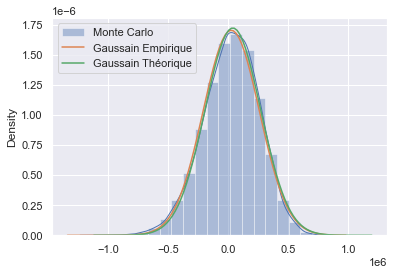

In [11]:

irs = portfolio

t = 2

Vt=irs.Mtm(t,diff,ZC)


sns.distplot(Vt, hist = True, bins=20, kde = True, kde_kws={ 'linewidth': 1}, label ='Monte Carlo')
# Plot the PDF.
xmin, xmax = plt.xlim()
ax = np.linspace(xmin, xmax, 100)
p = norm.pdf(ax, np.mean(Vt) ,  np.std(Vt))
m,s = Mtm_proxy_law(t,irs, lam, sig,ZC)

x_, x__ = m-5*s , m+5*s
ax_ = np.linspace(x_, x__, 100)

pt =  norm.pdf(ax_, m,s)
plt.plot(ax,p,label='Gaussain Empirique')
plt.plot(ax_,pt,label='Gaussain Théorique')

plt.legend()
plt.show()

In [12]:
 np.mean(Vt) ,  np.std(Vt)

(27451.483679322053, 234117.37613747228)

In [13]:
 Mtm_proxy_law(t,irs, lam, sig,ZC)

(40728.11301127655, 231528.79204624152)

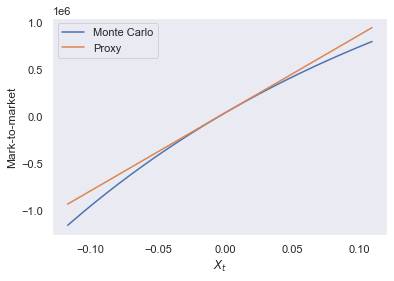

In [14]:
Xt= np.sort(diff.X(t))

Mtm_t = irs.Mtm_mono(t,Xt,ZC,diff.get_LGM_params())

a,b =  Mtm_proxy(t, portfolio, lam, sig, ZC)

plt.plot(Xt, Mtm_t,label='Monte Carlo' )
plt.plot(Xt , a+b*Xt , label='Proxy')
plt.xlabel('$X_{t}$')
plt.ylabel('Mark-to-market')
plt.grid(False)
plt.legend()

We remind that here $\sigma = 0.2 \%$

In [102]:
def Expected_exposure_proxy(t, portfolio, lam, sig, ZC) :
    mu , sigma = Mtm_proxy_law(t, portfolio, lam, sig, ZC)
    if sigma == 0:
        return 0
    return ZC.initial_zcb_curve(t)*(mu*norm.cdf(mu/sigma) + sigma*norm.pdf(mu/sigma))

def Expected_exposure_benchmark(t, portfolio, ZC, lgm_params , n_std, n_reim) : 
    lam, sig = lgm_params
    mu_X_t = 0
    std_X_t =sig * np.sqrt( (1 - np.exp(-2 * lam *t )) / (2 * lam) )

    train_range = ( mu_X_t-n_std*std_X_t, mu_X_t+n_std*std_X_t )

    # Pricing 
    X = np.linspace(train_range[0], train_range[1], n_reim)
    mtm = portfolio.Mtm_mono(t,X,ZC,lgm_params)

    Y = np.maximum(mtm, 0)*norm.pdf(X, mu_X_t, std_X_t)

    return ZC.initial_zcb_curve(t) * (np.diff(X)*Y[1:]).sum()

## 2. Test de validité sur $(\lambda , \sigma)$ en utilisant EE : 

In [178]:
t=3
sig_values = np.array([0.005,0.0075,0.01,0.0125,0.0150,0.0175,0.02,0.025,0.025])
lam_values = np.array([0.01,0.015, 0.02, 0.025, 0.03, 0.035, 0.04 ,0.045, 0.05])

In [36]:
# to RUN CALCULATION
# sig_values = np.array([0.005,0.0075,0.01,0.0125,0.0150,0.0175,0.02,0.025,0.025])
# lam_values = np.array([0.01,0.015, 0.02, 0.025, 0.03, 0.035, 0.04 ,0.045, 0.05])
# EE_proxy = np.empty((sig_values.shape[0] , lam_values.shape[0]))
# EE_MC =  np.empty((sig_values.shape[0] , lam_values.shape[0]))
# for sig in sig_values :
#     i = list(sig_values).index(sig)
#     for lam in lam_values :
#         j = list(lam_values).index(lam)
#         diff = Diffusion(0, T, n, sig, lam, 60000, pb_measure='Terminal at t')
        
#         EE_proxy[i,j] = Expected_exposure_proxy(t, portfolio, lam, sig, ZC)
#         EE_MC[i,j] = Expected_exposure_MC(t, portfolio, diff, ZC)


In [61]:
res = pd.DataFrame(100*abs(EE_proxy-EE_MC)/abs(EE_MC), columns= 100*lam_values, index=100*sig_values[:-1]).round(1)
res

,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
0.50,0.9,1.1,1.1,0.6,0.2,0.5,0.6,0.7,1.3
0.75,0.8,1.0,1.2,1.3,0.8,1.1,1.6,1.3,1.5
1.00,0.5,1.5,1.6,2.3,1.7,2.4,0.9,1.2,2.1
1.25,2.4,2.2,3.1,1.7,2.1,2.7,2.4,2.1,1.9
1.50,3.7,2.8,3.2,2.7,2.9,2.8,3.2,3.1,2.7
1.75,4.4,3.3,3.5,3.5,3.4,3.0,3.6,3.7,3.0
2.00,4.3,4.5,5.1,3.8,5.0,4.2,4.0,4.4,4.3
2.50,5.6,5.1,5.4,4.4,6.5,4.6,4.9,4.8,5.2


<Axes: >

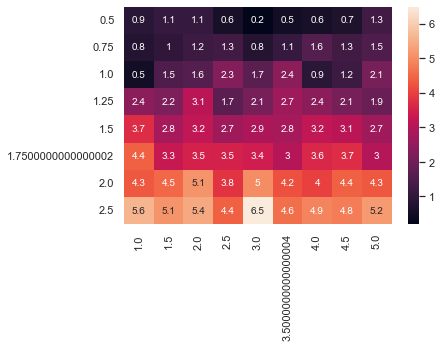

In [62]:
sns.heatmap(res, annot=True)

## 2. Test de validité sur $(\lambda , \sigma)$ pour la CVA : 

In [21]:
sig_values = np.array([0.005,0.01,0.0150,0.02])
lam_values = np.array([0.01, 0.02, 0.03, 0.04])


Comme la mean reav $\lambda$ n'influence pas beaucoup sur la qualité du proxy, les figures suivantes sont pour $\lambda =1\%$

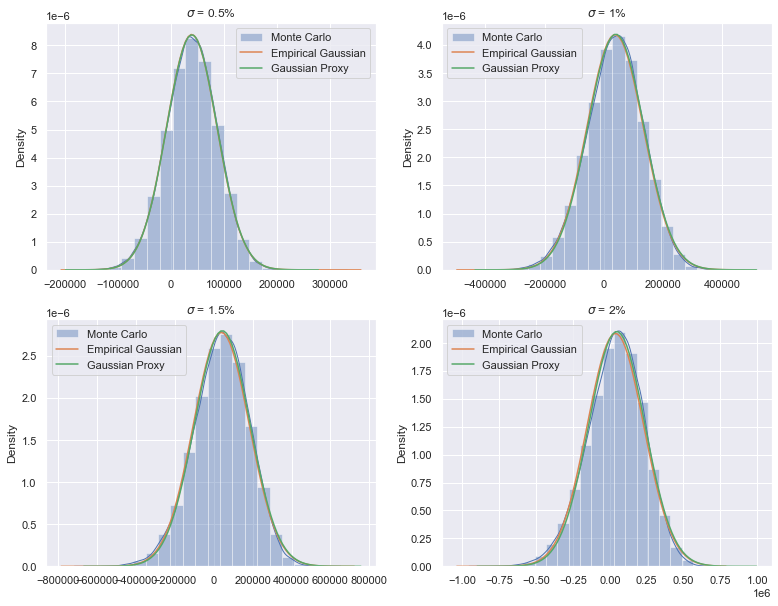

In [118]:
lam= 0.01
t= 3

fig, axes = plt.subplots(2,2, figsize=(13, 10))

for sig in sig_values :
    i = list(sig_values).index(sig)
    
    diff = Diffusion(0, T, n, sig, lam, 60000, pb_measure='Terminal at t')
    Vt=irs.Mtm(t,diff,ZC)
    
    plt.subplot(2,2,i+1)
    
    sns.distplot(Vt, hist = True, bins=20, kde = True, kde_kws={ 'linewidth': 1}, label ='Monte Carlo')
    # Plot the PDF
    xmin, xmax = plt.xlim()
    ax = np.linspace(xmin, xmax, 100)
    p = norm.pdf(ax, np.mean(Vt) ,  np.std(Vt))
    plt.plot(ax,p,label='Empirical Gaussian')
    
    m,s = Mtm_proxy_law(t,irs, lam, sig,ZC)
    x_, x__ = m-5*s , m+5*s
    ax_ = np.linspace(x_, x__, 100)
    pt =  norm.pdf(ax_, m,s)
    plt.plot(ax_,pt,label='Gaussian Proxy')
    
    if 100*sig%1 == 0:
        plt.title('$\sigma$ = '+str(int(100*sig))+'%')
    else :
        plt.title('$\sigma$ = '+str(100*sig)+'%')
    plt.legend()


In [11]:
# Save the following results 
proxy_path = project_path +'\Results\proxy'

In [22]:
#recovery rate & defult probability parameter :
R, lamda = 0.4, 0.005

time_grid = np.linspace(0,T,500)
PD = np.array([ lamda * np.exp(-lamda *t) for t in time_grid])
lam = 0.01



In [ ]:
# To Run Calculation 

# sig_values = np.array([0.01,0.0150,0.02])


# cva_proxy = np.empty(sig_values.shape[0] )
# cva_MC = np.empty(sig_values.shape[0])
# EE_proxy = np.empty((sig_values.shape[0] , 500 ))
# EE_MC =  np.empty((sig_values.shape[0], 500 ))

# for sig in sig_values :
#     i = list(sig_values).index(sig)

#     diff = Diffusion(0, T, n, sig, lam, 60000, pb_measure='Terminal at t')
#     print('------------ sig = ', sig)
    
#     tt= time()
#     EE = np.array([ Expected_exposure_proxy(t, portfolio, lam, sig, ZC)  if 0<t and t<T else 0 for t in time_grid])
#     cva_proxy[i] = (np.diff(time_grid)*((1-R)*EE*PD)[1:]).sum()
#     EE_proxy[i] = EE
#     print('proxy done in ', "{}".format(str( timedelta( seconds=round(time()-tt) ) )))
    
#     tt=time()
#     EE = np.array([ Expected_exposure_MC(t, portfolio, diff, ZC)  if 0<t and t<T else 0 for t in time_grid])
#     cva_MC[i] = (np.diff(time_grid)*((1-R)*EE*PD)[1:]).sum()
#     EE_MC[i] = EE
    
#     print('MC done in', "{}".format(str( timedelta( seconds=round(time()-tt) ) )))
    
#     with open(result_path+'\Cva_Robustness_test_lam1' ,'wb') as f:
#         pickle.dump(EE_MC,f)
#         pickle.dump(EE_proxy,f)
#         pickle.dump(cva_MC,f)
#         pickle.dump(cva_proxy,f)

# n_std , integ_pts = 5, 300
# cva_numerical_integ = np.empty(sig_values.shape[0])
# for sig in sig_values :
#     i = list(sig_values).index(sig)
    
#     diff = Diffusion(0, T, n, sig, lam, 60000, pb_measure='Terminal at t')
    
#     EE =np.array([ Expected_exposure_benchmark(t, portfolio, ZC, (lam,sig) , n_std, integ_pts)  if 0<t and t<T else 0 for t in time_grid])
#     Y = (1-R)*EE*PD
#     plt.plot(time_grid , EE, label=str(100*sig))
#     cva_numerical_integ[i] = (np.diff(time_grid)*Y[1:]).sum()



------------ sig =  0.01
proxy done in  0:00:10


In [172]:
# Get calculated resutlts 

with open(proxy_path+'\Cva_Robustness_test_lam1' ,'rb') as f:
    EE_MC = pickle.load(f)
    EE_proxy = pickle.load(f)
    cva_MC = pickle.load(f)
    cva_proxy =pickle.load(f)
    cva_integration=pickle.load(f)

In [173]:
cva_df = pd.DataFrame(columns=['Numerical Integration','Monte Carlo', 'Proxy'] , index=sig_values)

cva_df['Numerical Integration'] =cva_numerical_integ
cva_df['Monte Carlo'] =cva_MC
cva_df['Proxy'] =cva_proxy
cva_df = cva_df.astype(int) 
    

In [174]:
cva_df

,Numerical Integration,Monte Carlo,Proxy
0.005,432,431,435
0.010,629,628,642
0.015,845,841,874
0.020,1066,1062,1116


In [175]:
# Compute Error : Numerical integration is the benchmark
mtm = np.mean(portfolio.Mtm(0, diff,ZC))
cva_df['MC Error'] = np.abs( 100*(cva_df['Monte Carlo'] - cva_df['Numerical Integration'] )/mtm)
cva_df['Proxy Error'] = np.abs( 100*(cva_df['Proxy'] - cva_df['Numerical Integration'] )/mtm)

In [176]:
cva_df.round(2)

,Numerical Integration,Monte Carlo,Proxy,MC Error,Proxy Error
0.005,432,431,435,0.00,0.01
0.010,629,628,642,0.00,0.02
0.015,845,841,874,0.01,0.05
0.020,1066,1062,1116,0.01,0.09


  - Conclusion : The gaussian proxy is good for CVA calculations as $\sigma$ is small